# Model Development - Part I
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

This notebook implements the development of the model's base architecture.
- Reference models are examined for patterns.
- Based on the patterns, an architecture is designed and improved through adjustments.
- The positive adjustments are combined to obtain the best performing architecture.
- GPU can be used. 
- Training durations can be compared as training is performed on the same GPU.

The sections are as follows -
- [Convolutional Neural Networks](#cnn)
- [Load Files](#load_files)
- [Imports](#imports)
- [Data Preparation](#data_preparation)
- [Training Parameters](#training_parameters)
- [Model Parameters](#model_parameters)
- [Overview](#overview)
- [Reference Architectures](#ref_architectures)
- [Designed Architectures](#designed_architectures)
- [Selected Architecture](#selected_arch)
- [Input Improvements](#input_improvements)
- [Save File](#save_file)

<a id='cnn'></a>
## Convolutional Neural Networks
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

CNNs perform well in analysis and classification of images. Following are the components of a traditional CNN architecture -

**Convolutional Layer**
- A convolution is a combined integration of two functions that shows how one function modifies the other. 
- The main purpose of this layer is to detect visual features. Early layers learn basic features with latter layers learning more complex features.
- Filters (or kernels) are convolved with the inputs to obtain activation maps. Each filter is comprised of weights that are learnt during training in order to detect specific features. 
- It moves over the inputs with a specific stride to search for a feature carrying out an element-wise product and sum between two matrices. Presence of feature results in a high value. 
- Several filters are used on each layer to different features. 
- Inputs can be padded to avoid losing information from pixels on the edges.

**Activation Function**
- The maps are then passed through a non-linear activation function (ReLU) to introduce non-linearity into the network. 

**Pooling Layer**
- Reduces the spatial size of the feature maps to reduce processing time and prevent overfitting by limiting focus to a few neurons instead of the entire information.

**Flattening**
- The 3D representation of the image is flattened/reduced to a 1D feature vector which is fed to the hidden layers.

**Fully Connected Layer**
- This 1D layer is fully connected to the next layer, unlike a convolutional layer where kernels search locally.

<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

A combination of convolutional layer, activation, and pooling layer can be considered as a **feature extraction block**.
Typically, we have a sequence of such blocks followed by flattening to connect to the fully connected layers. For classification, the output of the fully connected section can be obtained as probabilities using a **softmax activation** function. This maps the outputs to a vector whose elements **sum up to 1**. For regression, the output can be passed through a regular activation function.

<a id='load_files'></a>
## Load Files
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

- Loading the IEMOCAP Spectrograms, IEMOCAP Meta, network module, visualization module, and helper module into the session storage (for use in Colab).
- Additionally installing `torchmetrics`.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/IEMOCAP Spectrograms.zip' 'IEMOCAP Spectrograms.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/IEMOCAP Meta.zip' 'IEMOCAP Meta.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/network.zip' 'network.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/visualization.zip' 'visualization.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/helper.zip' 'helper.zip'

!unzip 'IEMOCAP Spectrograms.zip'
!unzip 'IEMOCAP Meta.zip'
!unzip 'network.zip'
!unzip 'visualization.zip'
!unzip 'helper.zip'

!pip install torchmetrics

<a id='imports'></a>
## Imports
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Importing the required functions from the network module.
> `batch` - code for batch-related operations.
<br>
> `train` - code for training the network.
<br>
> `architecture` - code for specifying network architectures.

In [ ]:
import sys
sys.path.append('./network')

from network.batch import create_batches, get_augmentations
from network.train import get_simple_model, train_simple_network
from network.architecture import REF_ONE, REF_TWO, REF_THREE, REF_FOUR, STARTER

#### Step 2:
- Importing the required functions from the visualization module.
    > `explanation` - code for conducting explanatory visualizations.

In [ ]:
sys.path.append('./visualization')

from visualization.explanation import compare_simple

#### Step 3:
- Importing the required functions from the helper module.
    > `common` - code for general-purpose functions common among all modules.<br>
    > `network` - code for general-purpose functions of network module.
- Importing additional libraries.

In [ ]:
sys.path.append('./helper')

from helper.common import save_data
from helper.network import load_data, get_emotion_num, get_channel_stats, get_classification_metric, get_criterion

import copy

<a id='data_preparation'></a>
## Data Preparation
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Loading `label_data`, `split_data`, and `class_data`.

In [ ]:
root = './IEMOCAP Spectrograms'
meta_root = './IEMOCAP Meta'
roots = (root, meta_root)
name = 'iemocap'

label_data = load_data(meta_root, 'Label')
split_data = load_data(meta_root, 'Split')
class_data = load_data(meta_root, 'Class')

#### Step 2:
Obtaining number of outputs for emotion classification.

In [ ]:
num_classes = get_emotion_num(name, class_data)
print(f'Emotions: {num_classes}')

Emotions: 8


#### Step 3:
Obtaining the names of files in the train and valid sets. For this notebook, only original samples are considered for faster training.
> `num_augs` - number of augmentations to include. 1 represents the unaugmented spectrograms.

In [ ]:
train_data_aug = get_augmentations(split_data['train'], num_augs = [1])
valid_data_aug = get_augmentations(split_data['valid'], num_augs = [1])

#### Step 4:
- Creating train and valid batches. The data only includes the names of the files in the batches, not the inputs or labels.
> `batch_size` - number of batches. Kept as **64** for this notebook.<br>
> `shuffled_train` - shuffled train data to fill missing entries in the last batch, if required.<br>
> `shuffled_valid` - shuffled valid data to fill missing entries in the last batch, if required.

- Saving the batches for use during training.

In [ ]:
batch_size = 64

train_batches, shuffled_train = create_batches(train_data_aug, batch_size)
valid_batches, shuffled_valid = create_batches(valid_data_aug, batch_size)

data_batches = (train_batches, valid_batches)
shuffled_data = (shuffled_train, shuffled_valid)

batch_data = {'data batches': data_batches, 'shuffled data': shuffled_data, 'batch size': batch_size}
save_data(meta_root, batch_data, 'Batch Data (Dev)')

<a id='training_parameters'></a>
## Training Parameters
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
- Defining training parameters. Metrics selected are -
> - **Accuracy** - computes ratio of number of samples correctly classified to total number of samples.<br>
> - **F1 Score** - harmonic mean of precision and recall. Here, ${\beta}$ = 1 indicates equal weightage to precision and recall.

- Additionally, `average_type` is the method of averaging classification metric results. The chosen method is -
> **weighted** - calculates the metric for each class separately, and averages the metrics across classes, weighting each class by its support (`tp` + `fn`). This is good for an imbalanced dataset.<br>

In [ ]:
metrics = get_classification_metric('weighted', num_emotion = num_classes)

#### Step 2:
Defining loss function (`criterion`) - 
> **Categorical** - loss function for categorical labels is **Negative Log-likelihood Loss**. Since predictions are obtained through **Log Softmax**, they both combine to form the **Categorical Cross Entropy Loss**.<br>

In [ ]:
criterion = get_criterion(['classification'])[0]

#### Step 2:
Packing the training parameters.
> **Epochs** - training for 10 epochs.

In [ ]:
epochs = 10

torch_params = {'criterion': criterion, 'metrics': metrics}
other_params = {'epochs': epochs, 'batch size': batch_size}

<a id='model_parameters'></a>
## Model Parameters
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

Defining the input normalization transform. Each channel is transformed using $\frac{\text{channel input} \text{ - } \text{channel mean}}{\text{channel std}}$.
> `color_map` - currently set to 'L' for **grayscale** images. Number of channels will be **1**.<br>
> `channel_mean` - **0.5** for each channel, for now.<br>
> `channel_std` - **0.5** for each channel, for now.

In [ ]:
color_map = 'L'
channel_mean, channel_std = [0.5], [0.5]

transforms = [channel_mean, channel_std, color_map]

<a id='overview'></a>
## Overview
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

- Comparison is performed through their training loss, validation loss, accuracy, and f1 score.

- `get_simple_model` performs the following -
    > - Assignment of input image size, model input size, and model output size.<br>
    > - Instantiation of the model.<br>
    > - Instantiation of the **Stochastic Gradient Descent** optimizer with a learning rate of **0.01**.
    
- `train_simple_network` performs training and validation of the model -
> - In each epoch, batch is loaded and transformations are applied.
> - Before normalization, each image is resized and converted to a tensor.

- `plotting_data` - stores results of training for all models.

In [ ]:
plotting_data = {}

<a id='ref_architectures'></a>
## Reference Architectures
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

Each reference architecture is trained and its features are examined.

#### Reference 1:
A. M. Badshah, J. Ahmad, N. Rahim and S. W. Baik, "Speech Emotion Recognition from Spectrograms with Deep Convolutional Neural Network," 2017 International Conference on Platform Technology and Service (PlatCon), 2017, pp. 1-5, doi:10.1109/PlatCon.2017.7883728.
> Features -
> - Large kernel size.<br>
> - Early downsampling with stride.<br>
> - 3 conv-pool layers.<br>
> - Large number of kernels.

> https://www.researchgate.net/publication/315638464_Speech_Emotion_Recognition_from_Spectrograms_with_Deep_Convolutional_Neural_Network

Layout -
- `input` - (256 x 256 x 1)
- `layers` -

| Layer | Size | Input Depth | Output Depth | Kernel | Stride| Padding | 
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Conv 1 | 86 x 86 x 120 | 1 | 120 | 11 | 3 | 5
| Pool 1 | 42 x 42 x 120 | - | - | 4 | 2 | -
| Conv 2 | 42 x 42 x 256 | 120 | 256 | 5 | 1 | 2
| Pool 2 | 20 x 20 x 256 | - | - | 4 | 2 | -
| Conv 3 | 20 x 20 x 384 | 256 | 384 | 3 | 1 | 1
| Pool 3 | 9 x 9 x 384 | - | - | 4 | 2 | -

| Layer | Input | Output | 
| :-- | :-: | :-: |
| Full 1 | 31104 | 8192 |
| Full 2 | 8192 | 2048 |

- `output` - 8


In [ ]:
model_params = get_simple_model(REF_ONE, transforms, num_classes)
plotting_data['REF ONE'] = train_simple_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

#### Reference 2:
Somayeh Shahsavarani, "Speech Emotion Recognition using Convolutional Neural Networks", Masters dissertation,The Graduate College, University of Nebraska, Lincoln 2018. Accessed on: August 23, 2021.
> Features -
> - Small image size.<br>
> - No downsampling with stride.<br>
> - 2 conv-pool layers.<br>
> - Small number of kernels.

> https://digitalcommons.unl.edu/cgi/viewcontent.cgi?article=1165&context=computerscidiss

Layout -
- `input` - (128 x 128 x 1)
- `layers` -

| Layer | Size | Input Depth | Output Depth | Kernel | Stride| Padding | 
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Conv 1 | 128 x 128 x 8 | 1 | 8 | 5 | 1 | 2
| Pool 1 | 64 x 64 x 8 | - | - | 2 | 2 | -
| Conv 2 | 64 x 64 x 16 | 8 | 16 | 5 | 1 | 2
| Pool 2 | 32 x 32 x 16 | - | - | 2 | 2 | -

| Layer | Input | Output | 
| :-- | :-: | :-: |
| Full 1 | 16384 | 2048 |

- `output` - 8

In [ ]:
model_params = get_simple_model(REF_TWO, transforms, num_classes)
plotting_data['REF TWO'] = train_simple_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model REF ONE | Training Duration = 619.57 sec | Average Duration = 61.96 sec
Model REF TWO | Training Duration = 549.01 sec | Average Duration = 54.90 sec


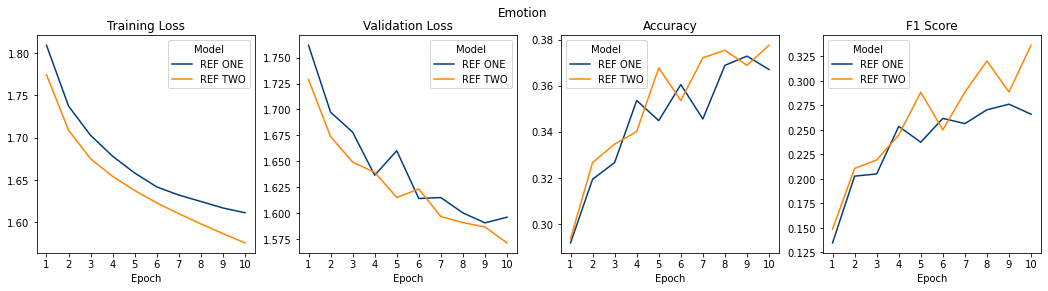

In [ ]:
compare_simple(plotting_data['REF ONE'], 'REF ONE', plotting_data['REF TWO'], 'REF TWO', epochs)

#### Comparison (REF ONE and REF TWO):

| Architecture | Training Loss | Validation Loss | Accuracy | F1 Score |
| :-- | :-: | :-: | :-: | :-: |
| REF ONE | &#10006; | &#10006; | &#10006; | &#10006; |
| REF TWO | &#10004; | &#10004; | &#10004; | &#10004; |

> **Winner** - REF TWO

#### Reference 3:
Kim, N., Lee, J., Ha, H., Lee, G., Lee, J. and Kim, H., 2017. Speech Emotion Recognition Based on Multi-task Learning using a Convolutional Neural Network. In: 2017 APSIPA Annual Summit and Conference. pp.704-707.
> Features -
> - Small image size.<br>
> - No downsampling with stride.<br>
> - 2 conv-pool layers.<br>
> - Small number of kernels.

> https://www.researchgate.net/publication/323193422_Speech_emotion_recognition_based_on_multi-task_learning_using_a_convolutional_neural_network

Layout -
- `input` - (128 x 128 x 1)
- `layers` -

| Layer | Size | Input Depth | Output Depth | Kernel | Stride| Padding | 
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Conv 1 | 128 x 128 x 32 | 1 | 32 | 5 | 1 | 2
| Pool 1 | 64 x 64 x 32 | - | - | 2 | 2 | -
| Conv 2 | 64 x 64 x 32 | 32 | 32 | 3 | 1 | 1
| Pool 2 | 32 x 32 x 32 | - | - | 2 | 2 | -

| Layer | Input | Output | 
| :-- | :-: | :-: |
| Full 1 | 32768 | 2048 |

- `output` - 8


In [ ]:
model_params = get_simple_model(REF_THREE, transforms, num_classes)
plotting_data['REF THREE'] = train_simple_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model REF TWO | Training Duration = 549.01 sec | Average Duration = 54.90 sec
Model REF THREE | Training Duration = 577.02 sec | Average Duration = 57.70 sec


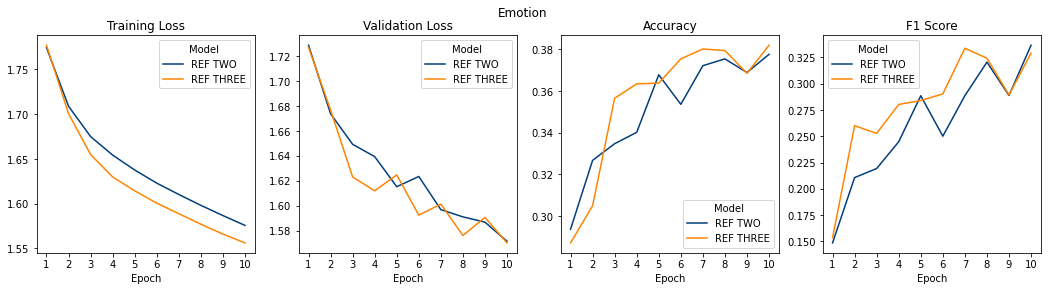

In [ ]:
compare_simple(plotting_data['REF TWO'], 'REF TWO', plotting_data['REF THREE'], 'REF THREE', epochs)

#### Comparison (REF TWO and REF THREE):

| Architecture | Training Loss | Validation Loss | Accuracy | F1 Score |
| :-- | :-: | :-: | :-: | :-: |
| REF TWO | &#10006; | &#10004; | &#10006; | &#10004; |
| REF THREE | &#10004; | &#10004; | &#10004; | &#10004; |

> **Winner** - REF THREE

#### Reference 4 (AlexNet):
Krizhevsky, A., Sutskever, I. and Hinton, G., 2012. ImageNet Classification with Deep Convolutional Neural Networks. In: 25th International Conference on Neural Information Processing Systems. NY, United States: Curran Associates Inc., pp.1097–1105. 
> Features -
> - Large kernel size.<br>
> - Early downsampling with stride.<br>
> - 5 conv and 3 pool layers.<br>
> - Large number of kernels.

> https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

Layout -
- `input` - (227 x 227 x 1)
- `layers` -

| Layer | Size | Input Depth | Output Depth | Kernel | Stride| Padding | 
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Conv 1 | 55 x 55 x 96 | 1 | 96 | 11 | 4 | 0
| Pool 1 | 27 x 27 x 96 | - | - | 3 | 2 | -
| Conv 2 | 27 x 27 x 256 | 96 | 256 | 5 | 1 | 2
| Pool 2 | 13 x 13 x 256 | - | - | 3 | 2 | -
| Conv 3 | 13 x 13 x 384 | 256 | 384 | 3 | 1 | 1
| Conv 4 | 13 x 13 x 384 | 384 | 384 | 3 | 1 | 1
| Conv 5 | 13 x 13 x 256 | 384 | 256 | 3 | 1 | 1
| Pool 3 | 6 x 6 x 256 | - | - | 3 | 2 | -

| Layer | Input | Output | 
| :-- | :-: | :-: |
| Full 1 | 9216 | 4096 |
| Full 2 | 4096 | 4096 |
| Full 3 | 4096 | 1000 |

- `output` - 8

In [ ]:
model_params = get_simple_model(REF_FOUR, transforms, num_classes)
plotting_data['REF FOUR'] = train_simple_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model REF THREE | Training Duration = 577.02 sec | Average Duration = 57.70 sec
Model REF FOUR | Training Duration = 654.59 sec | Average Duration = 65.46 sec


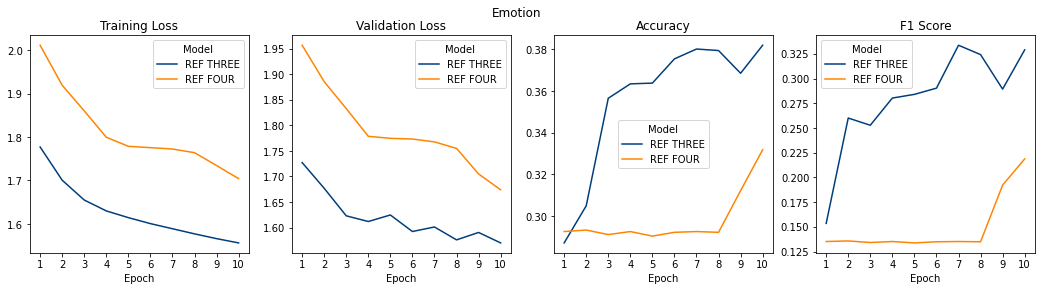

In [ ]:
compare_simple(plotting_data['REF THREE'], 'REF THREE', plotting_data['REF FOUR'], 'REF FOUR', epochs)

#### Comparison (REF THREE and REF FOUR):

| Architecture | Training Loss | Validation Loss | Accuracy | F1 Score |
| :-- | :-: | :-: | :-: | :-: |
| REF THREE | &#10004; | &#10004; | &#10004; | &#10004; |
| REF FOUR | &#10006; | &#10006; | &#10006; | &#10006; |

> **Winner** - REF THREE

#### Result:
`REF_TWO` has shown the best performance.

The reasons for poor performance can be linked to - 
- Deep networks having several conv-pool layers.
- Large image sizes (small networks prefer small images).
- Downsampling with stride when image size is large.

Thus, we make the following conclusions -
- Number of conv-pool layers should be small.
- Image size should be small.
- Downsampling with stride is not required.

<a id='designed_architectures'></a>
## Designed Architectures
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Overview
- An architecture is designed based on the features of the reference architectures.
- Adjustments are made and checked for their affect on performance.
- Comparison is performed through their training loss, validation loss, accuracy, and f1 score.

> The features that will be kept constant are -
> - Small number of conv-pool layers.
> - Small image size.
> - No downsampling with stride.
> - Small number of kernels.

> The features that will be manipulated are -
> - Number of conv-pool layers.
> - Pooling kernel size.
> - Kernel size.
> - Number of kernels.
> - Size of hidden layer.

#### Arch 1:
A simple starting architecture.
> Features -
> - 2 conv-pool layers.<br>
> - Non-overlapping pooling.<br>
> - Small kernel size.<br>
> - Less number of kernels.<br>
> - Small hidden layer.

Layout -
- `input` - (128 x 128 x 1)
- `layers` -

| Layer | Size | Input Depth | Output Depth | Kernel | Stride| Padding | 
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Conv 1 | 128 x 128 x 16 | 1 | 16 | 3 | 1 | 1
| Pool 1 | 64 x 64 x 16 | - | - | 2 | 2 | -
| Conv 2 | 64 x 64 x 32 | 16 | 32 | 3 | 1 | 1
| Pool 2 | 32 x 32 x 32 | - | - | 2 | 2 | -

| Layer | Input | Output | 
| :-- | :-: | :-: |
| Full 1 | 32768 | 2048 |

- `output` - 8


In [ ]:
ONE = copy.deepcopy(STARTER)
model_params = get_simple_model(ONE, transforms, num_classes)
plotting_data['ONE'] = train_simple_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model REF THREE | Training Duration = 577.02 sec | Average Duration = 57.70 sec
Model ONE | Training Duration = 559.64 sec | Average Duration = 55.96 sec


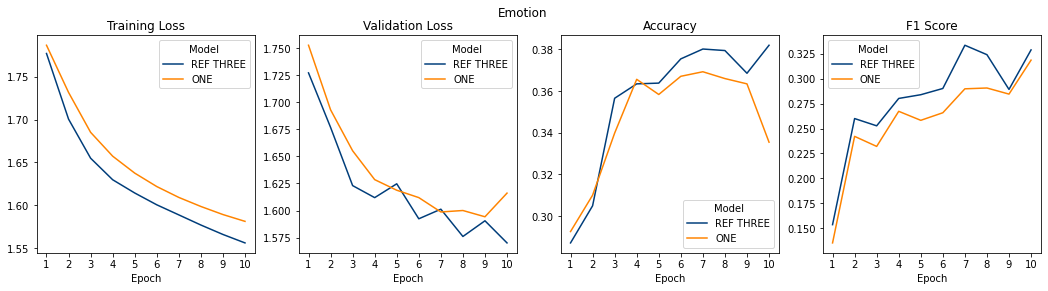

In [ ]:
compare_simple(plotting_data['REF THREE'], 'REF THREE', plotting_data['ONE'], 'ONE', epochs)

#### Comparison (REF THREE and ONE):

| Architecture | Training Loss | Validation Loss | Accuracy | F1 Score |
| :-- | :-: | :-: | :-: | :-: |
| REF THREE | &#10004; | &#10004; | &#10004; | &#10004; |
| ONE | &#10006; | &#10006; | &#10006; | &#10006; |

> **Winner** - REF THREE

#### Arch 2:
Inserting a third conv-pool layer.

Layout -
- `input` - (128 x 128 x 1)
- `layers` -

| Layer | Size | Input Depth | Output Depth | Kernel | Stride| Padding | 
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Conv 1 | 128 x 128 x 16 | 1 | 16 | 3 | 1 | 1
| Pool 1 | 64 x 64 x 16 | - | - | 2 | 2 | -
| Conv 2 | 64 x 64 x 32 | 16 | 32 | 3 | 1 | 1
| Pool 2 | 32 x 32 x 32 | - | - | 2 | 2 | -
| Conv 3 | 32 x 32 x 64 | 32 | 64 | 3 | 1 | 1
| Pool 3 | 16 x 16 x 64 | - | - | 2 | 2 | -

| Layer | Input | Output | 
| :-- | :-: | :-: |
| Full 1 | 16384 | 2048 |

- `output` - 8


In [ ]:
TWO = copy.deepcopy(STARTER)
TWO['convolutional'].append({'input': 32, 'output': 64, 'kernel': 3, 'stride': 1, 'padding': 1})
TWO['pooling'].append({'kernel': 2, 'stride': 2})
TWO['pool position'] =  [1, 2, 3]
TWO['hidden'][0] = {'input': 16384, 'output': 2048}

In [ ]:
model_params = get_simple_model(TWO, transforms, num_classes)
plotting_data['TWO'] = train_simple_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model REF THREE | Training Duration = 577.02 sec | Average Duration = 57.70 sec
Model TWO | Training Duration = 554.56 sec | Average Duration = 55.46 sec


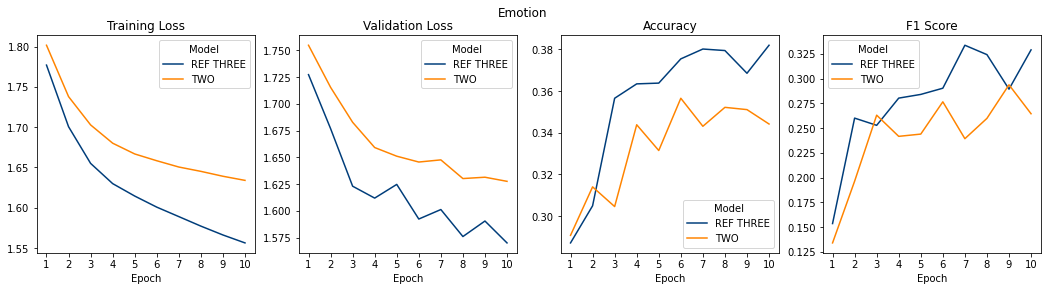

In [ ]:
compare_simple(plotting_data['REF THREE'], 'REF THREE', plotting_data['TWO'], 'TWO', epochs)

#### Comparison (REF THREE and TWO):

| Architecture | Training Loss | Validation Loss | Accuracy | F1 Score |
| :-- | :-: | :-: | :-: | :-: |
| REF THREE | &#10004; | &#10004; | &#10004; | &#10004; |
| TWO | &#10006; | &#10006; | &#10006; | &#10006; |

> **Winner** - REF THREE

#### Arch 3:
Increasing pooling kernel sizes.<br>
Layout -
- `input` - (128 x 128 x 1)
- `layers` -

| Layer | Size | Input Depth | Output Depth | Kernel | Stride| Padding | 
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Conv 1 | 128 x 128 x 16 | 1 | 16 | 3 | 1 | 1
| Pool 1 | 63 x 63 x 16 | - | - | 4 | 2 | -
| Conv 2 | 63 x 63 x 32 | 16 | 32 | 3 | 1 | 1
| Pool 2 | 31 x 31 x 32 | - | - | 3 | 2 | -

| Layer | Input | Output | 
| :-- | :-: | :-: |
| Full 1 | 30752 | 2048 |

- `output` - 8


In [ ]:
THREE = copy.deepcopy(STARTER)
THREE['pooling'][0]['kernel'] = 4
THREE['pooling'][1]['kernel'] = 3
THREE['hidden'][0]['input'] = 30752

In [ ]:
model_params = get_simple_model(THREE, transforms, num_classes)
plotting_data['THREE'] = train_simple_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model REF THREE | Training Duration = 577.02 sec | Average Duration = 57.70 sec
Model THREE | Training Duration = 555.62 sec | Average Duration = 55.56 sec


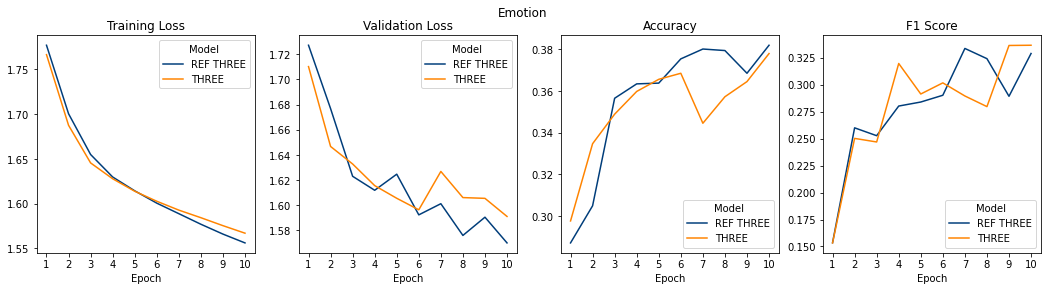

In [ ]:
compare_simple(plotting_data['REF THREE'], 'REF THREE', plotting_data['THREE'], 'THREE', epochs)

#### Comparison (REF THREE and THREE):

| Architecture | Training Loss | Validation Loss | Accuracy | F1 Score |
| :-- | :-: | :-: | :-: | :-: |
| REF THREE | &#10004; | &#10004; | &#10004; | &#10006; |
| THREE | &#10006; | &#10006; | &#10006; | &#10004; |

> **Winner** - REF THREE<br>
> **Insight** - performance has increased.

#### Arch 4:
Increasing kernel size in both convolutional layers.<br>
Layout -
- `input` - (128 x 128 x 1)
- `layers` -

| Layer | Size | Input Depth | Output Depth | Kernel | Stride| Padding | 
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Conv 1 | 128 x 128 x 16 | 1 | 16 | 7 | 1 | 3
| Pool 1 | 64 x 64 x 16 | - | - | 2 | 2 | -
| Conv 2 | 64 x 64 x 32 | 16 | 32 | 5 | 1 | 2
| Pool 2 | 32 x 32 x 32 | - | - | 2 | 2 | -

| Layer | Input | Output | 
| :-- | :-: | :-: |
| Full 1 | 32768 | 2048 |

- `output` - 8


In [ ]:
FOUR = copy.deepcopy(STARTER)
FOUR['convolutional'][0]['kernel'] = 7
FOUR['convolutional'][0]['padding'] = 3
FOUR['convolutional'][1]['kernel'] = 5
FOUR['convolutional'][1]['padding'] = 2

In [ ]:
model_params = get_simple_model(FOUR, transforms, num_classes)
plotting_data['FOUR'] = train_simple_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model REF THREE | Training Duration = 577.02 sec | Average Duration = 57.70 sec
Model FOUR | Training Duration = 569.67 sec | Average Duration = 56.97 sec


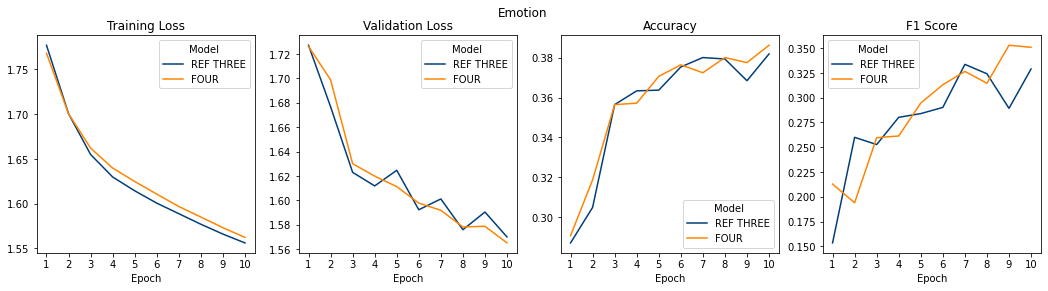

In [ ]:
compare_simple(plotting_data['REF THREE'], 'REF THREE', plotting_data['FOUR'], 'FOUR', epochs)

#### Comparison (REF THREE and FOUR):

| Architecture | Training Loss | Validation Loss | Accuracy | F1 Score |
| :-- | :-: | :-: | :-: | :-: |
| REF THREE | &#10004; | &#10006; | &#10006; | &#10006; |
| FOUR | &#10006; | &#10004; | &#10004; | &#10004; |

> **Winner** - FOUR<br>
> **Insight** - better performance.

#### Arch 5:
Increasing number of kernels in convolutional layers.<br>
Layout -
- `input` - (128 x 128 x 1)
- `layers` -

| Layer | Size | Input Depth | Output Depth | Kernel | Stride| Padding | 
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Conv 1 | 128 x 128 x 32 | 1 | 32 | 3 | 1 | 1
| Pool 1 | 64 x 64 x 32 | - | - | 2 | 2 | -
| Conv 2 | 64 x 64 x 64 | 32 | 64 | 3 | 1 | 1
| Pool 2 | 32 x 32 x 64 | - | - | 2 | 2 | -

| Layer | Input | Output | 
| :-- | :-: | :-: |
| Full 1 | 65536 | 2048 |

- `output` - 8


In [ ]:
FIVE = copy.deepcopy(STARTER)
FIVE['convolutional'][0]['output'] = 32
FIVE['convolutional'][1]['input'] = 32
FIVE['convolutional'][1]['output'] = 64
FIVE['hidden'][0]['input'] = 65536 

In [ ]:
model_params = get_simple_model(FIVE, transforms, num_classes)
plotting_data['FIVE'] = train_simple_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model REF THREE | Training Duration = 577.02 sec | Average Duration = 57.70 sec
Model FIVE | Training Duration = 579.05 sec | Average Duration = 57.90 sec


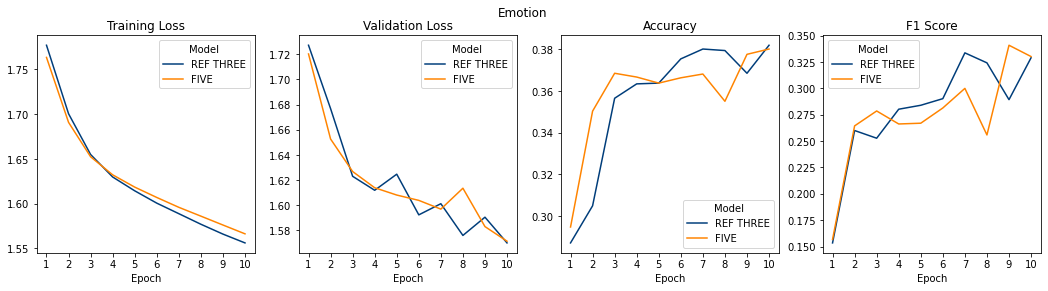

In [ ]:
compare_simple(plotting_data['REF THREE'], 'REF THREE', plotting_data['FIVE'], 'FIVE', epochs)

#### Comparison (REF THREE and FIVE):

| Architecture | Training Loss | Validation Loss | Accuracy | F1 Score |
| :-- | :-: | :-: | :-: | :-: |
| REF THREE | &#10004; | &#10004; | &#10004; | &#10004; |
| FIVE | &#10006; | &#10004; | &#10004; | &#10004; |

> **Winner** - REF THREE<br>
> **Insight** - performance has increased.

#### Arch 6:
Increasing number of neurons in hidden layer.
Layout -
- `input` - (128 x 128 x 1)
- `layers` -

| Layer | Size | Input Depth | Output Depth | Kernel | Stride| Padding | 
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Conv 1 | 128 x 128 x 16 | 1 | 16 | 3 | 1 | 1
| Pool 1 | 64 x 64 x 16 | - | - | 2 | 2 | -
| Conv 2 | 64 x 64 x 32 | 16 | 32 | 3 | 1 | 1
| Pool 2 | 32 x 32 x 32 | - | - | 2 | 2 | -

| Layer | Input | Output | 
| :-- | :-: | :-: |
| Full 1 | 32768 | 4096 |

- `output` - 8


In [ ]:
SIX = copy.deepcopy(STARTER)
SIX['hidden'][0]['output'] = 4096 

In [ ]:
model_params = get_simple_model(SIX, transforms, num_classes)
plotting_data['SIX'] = train_simple_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model REF THREE | Training Duration = 577.02 sec | Average Duration = 57.70 sec
Model SIX | Training Duration = 564.19 sec | Average Duration = 56.42 sec


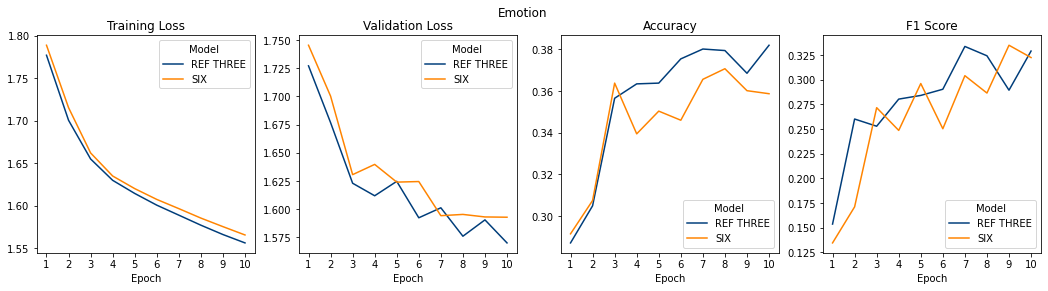

In [ ]:
compare_simple(plotting_data['REF THREE'], 'REF THREE', plotting_data['SIX'], 'SIX', epochs)

#### Comparison (REF THREE and SIX):

| Architecture | Training Loss | Validation Loss | Accuracy | F1 Score |
| :-- | :-: | :-: | :-: | :-: |
| REF THREE | &#10004; | &#10004; | &#10004; | &#10004; |
| SIX | &#10006; | &#10006; | &#10006; | &#10004; |

> **Winner** - REF THREE

<a id='selected_arch'></a>
## Selected Architecture
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Overview
- `FOUR` has shown better performance through increasing the kernel size.

- `THREE` and `FIVE` have shown an increase in performance of the `STARTER`. The factors that contributed to this are -
  - Overlapping pooling.
  - Increasing number of kernels.

#### Arch 7:
Combining the features of `THREE` and `FIVE`. 

Layout -
- `input` - (128 x 128 x 1)
- `layers` -

| Layer | Size | Input Depth | Output Depth | Kernel | Stride| Padding | 
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Conv 1 | 128 x 128 x 32 | 1 | 16 | 7 | 1 | 3
| Pool 1 | 64 x 64 x 32 | - | - | 4 | 2 | -
| Conv 2 | 64 x 64 x 64 | 16 | 32 | 5 | 1 | 2
| Pool 2 | 32 x 32 x 64 | - | - | 3 | 2 | -

| Layer | Input | Output | 
| :-- | :-: | :-: |
| Full 1 | 30752 | 2048 |

- `output` - 8

In [ ]:
SEVEN = copy.deepcopy(STARTER)
SEVEN['convolutional'][0]['kernel'] = 7
SEVEN['convolutional'][0]['padding'] = 3
SEVEN['convolutional'][1]['kernel'] = 5
SEVEN['convolutional'][1]['padding'] = 2

SEVEN['pooling'][0]['kernel'] = 4
SEVEN['pooling'][1]['kernel'] = 3

SEVEN['hidden'][0]['input'] = 30752

In [ ]:
model_params = get_simple_model(SEVEN, transforms, num_classes)
plotting_data['SEVEN'] = train_simple_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model REF THREE | Training Duration = 577.02 sec | Average Duration = 57.70 sec
Model SEVEN | Training Duration = 577.36 sec | Average Duration = 57.74 sec


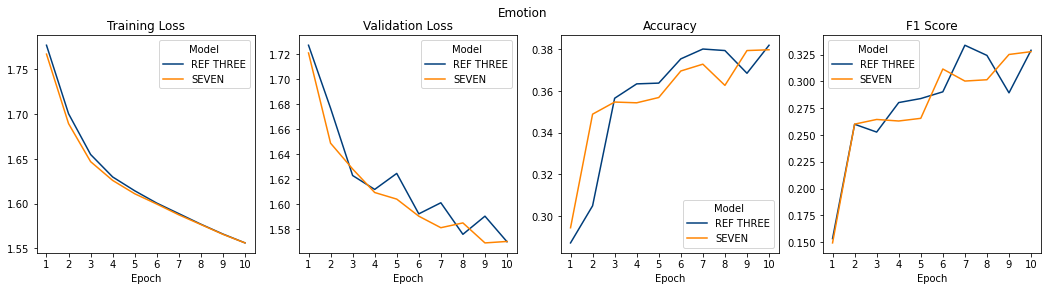

In [ ]:
compare_simple(plotting_data['REF THREE'], 'REF THREE', plotting_data['SEVEN'], 'SEVEN', epochs)

#### Comparison (REF THREE and SEVEN):

| Architecture | Training Loss | Validation Loss | Accuracy | F1 Score |
| :-- | :-: | :-: | :-: | :-: |
| REF THREE | &#10004; | &#10004; | &#10004; | &#10004; |
| SEVEN | &#10004; | &#10004; | &#10004; | &#10004; |

> **Winner** - SEVEN<br>
> **Insight** - equal performance.

Total Epochs = 10
Model FOUR | Training Duration = 569.67 sec | Average Duration = 56.97 sec
Model SEVEN | Training Duration = 577.36 sec | Average Duration = 57.74 sec


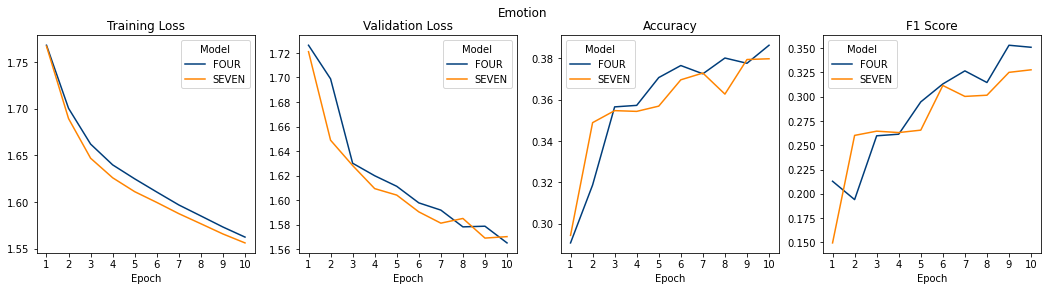

In [ ]:
compare_simple(plotting_data['FOUR'], 'FOUR', plotting_data['SEVEN'], 'SEVEN', epochs)

#### Comparison (FOUR and SEVEN):

| Architecture | Training Loss | Validation Loss | Accuracy | F1 Score |
| :-- | :-: | :-: | :-: | :-: |
| FOUR | &#10006; | &#10004; | &#10004; | &#10004; |
| SEVEN | &#10004; | &#10004; | &#10006; | &#10006; |

> **Winner** - FOUR<br>

#### Arch 8:
Combining the features of `SEVEN` and `FOUR`. 

Layout -
- `input` - (128 x 128 x 1)
- `layers` -

| Layer | Size | Input Depth | Output Depth | Kernel | Stride| Padding | 
| :-- | :-: | :-: | :-: | :-: | :-: | :-: |
| Conv 1 | 128 x 128 x 32 | 1 | 32 | 7 | 1 | 3
| Pool 1 | 64 x 64 x 32 | - | - | 4 | 2 | -
| Conv 2 | 64 x 64 x 64 | 32 | 64 | 5 | 1 | 2
| Pool 2 | 32 x 32 x 64 | - | - | 3 | 2 | -

| Layer | Input | Output | 
| :-- | :-: | :-: |
| Full 1 | 61504 | 2048 |

- `output` - 8

In [ ]:
EIGHT = copy.deepcopy(STARTER)
EIGHT['convolutional'][0]['kernel'] = 7
EIGHT['convolutional'][0]['padding'] = 3
EIGHT['convolutional'][1]['kernel'] = 5
EIGHT['convolutional'][1]['padding'] = 2

EIGHT['pooling'][0]['kernel'] = 4
EIGHT['pooling'][1]['kernel'] = 3

EIGHT['convolutional'][0]['output'] = 32
EIGHT['convolutional'][1]['input'] = 32
EIGHT['convolutional'][1]['output'] = 64
EIGHT['hidden'][0]['input'] = 61504

In [ ]:
model_params = get_simple_model(EIGHT, transforms, num_classes)
plotting_data['EIGHT'] = train_simple_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model EIGHT | Training Duration = 598.91 sec | Average Duration = 59.89 sec
Model FOUR | Training Duration = 569.67 sec | Average Duration = 56.97 sec


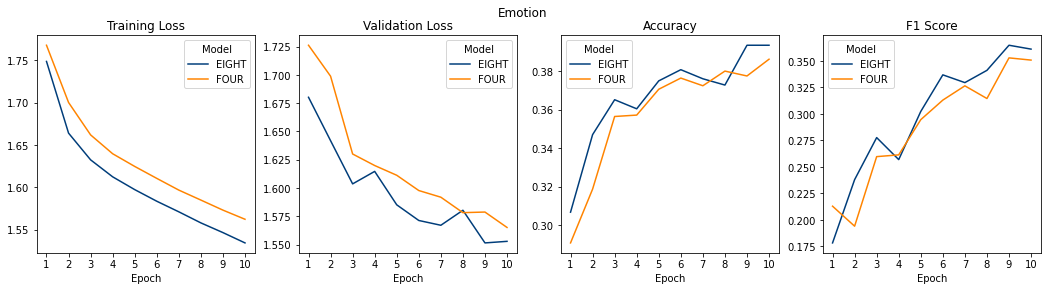

In [ ]:
compare_simple(plotting_data['EIGHT'], 'EIGHT', plotting_data['FOUR'], 'FOUR', epochs)

#### Comparison (EIGHT and FOUR):

| Architecture | Training Loss | Validation Loss | Accuracy | F1 Score |
| :-- | :-: | :-: | :-: | :-: |
| EIGHT | &#10004; | &#10004; | &#10004; | &#10004; |
| FOUR | &#10006; | &#10006; | &#10006; | &#10006; |

> **Winner** - EIGHT

#### Result:
`EIGHT` has shown the best performance and is the selected architecture.

<a id='input_improvements'></a>
## Input Improvements
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

- The selected architecture is tweaked in terms of - 
    - Color of image
    - Normalization transform

- Comparison is performed through their training loss, validation loss, accuracy, and f1 score.

#### Color:
> `color_map` - set to 'RGB' for **color** images. Number of channels will be **3**.<br>
> `channel_mean` - **0.5** for each channel, for now.<br>
> `channel_std` - **0.5** for each channel, for now.

- Arch 8 will have an input of depth 3.<br>
- `input` - (128 x 128 x 3)
- `layers` -

| Layer | Input Depth | 
| :-- | :-: |
| Conv 1 | 3 |

In [ ]:
color_map = 'RGB'
channel_mean, channel_std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
transforms = [channel_mean, channel_std, color_map]

In [ ]:
model_params = get_simple_model(EIGHT, transforms, num_classes)
plotting_data['EIGHT RGB'] = train_simple_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model EIGHT RGB | Training Duration = 681.30 sec | Average Duration = 68.13 sec
Model EIGHT L | Training Duration = 598.91 sec | Average Duration = 59.89 sec


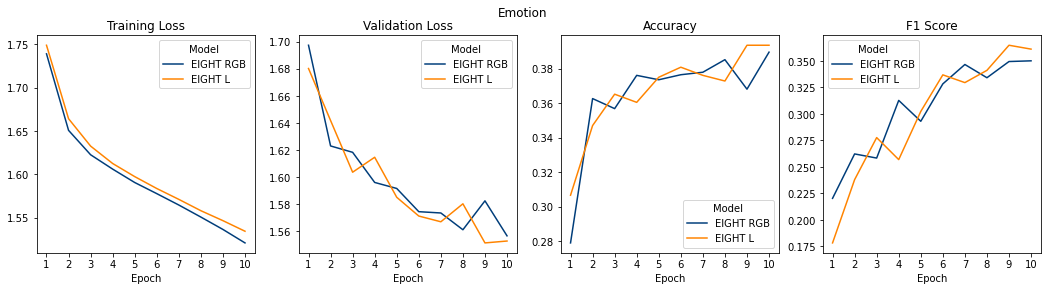

In [ ]:
compare_simple(plotting_data['EIGHT RGB'], 'EIGHT RGB', plotting_data['EIGHT'], 'EIGHT L', epochs)

#### Comparison (EIGHT RGB and EIGHT L):

| Architecture | Training Loss | Validation Loss | Accuracy | F1 Score |
| :-- | :-: | :-: | :-: | :-: |
| EIGHT RGB | &#10004; | &#10006; | &#10006; | &#10006; |
| EIGHT L | &#10006; | &#10004; | &#10004; | &#10004; |

> **Winner** - EIGHT L<br>
> **Insight** - grayscale images will be used.

#### Normalization:
Using statistics calculated from the dataset.
> `channel_mean` - value is set by calculating the mean of each channel across all unaugmented images of the dataset.<br>
> `channel_std` - value is set by calculating the std of each channel across all unaugmented images of the dataset.

In [ ]:
color_map = 'L'
channel_mean, channel_std = get_channel_stats(root, split_data, label_data, color_map)

transforms = [channel_mean, channel_std, color_map]
print(f'Channel Mean - {transforms[0]} | Channel Std - {transforms[1]}')

Channel Mean - [0.2746834] | Channel Std - [0.17490943]


In [ ]:
model_params = get_simple_model(EIGHT, transforms, num_classes)
plotting_data['EIGHT custom'] = train_simple_network(roots, model_params, torch_params, other_params)

IntProgress(value=0, description='Epoch - 0 / 10', layout=Layout(width='500px'), max=10, style=ProgressStyle(d…

Total Epochs = 10
Model EIGHT custom | Training Duration = 598.50 sec | Average Duration = 59.85 sec
Model EIGHT std | Training Duration = 598.91 sec | Average Duration = 59.89 sec


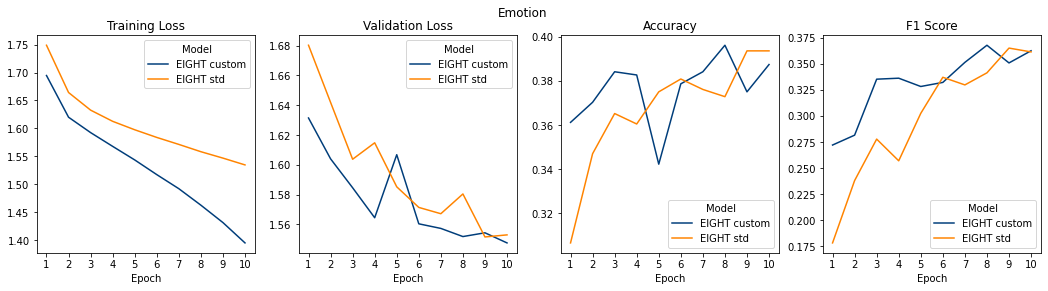

In [ ]:
compare_simple(plotting_data['EIGHT custom'], 'EIGHT custom', plotting_data['EIGHT'], 'EIGHT std', epochs)

#### Comparison (EIGHT custom and EIGHT std):

| Architecture | Training Loss | Validation Loss | Accuracy | F1 Score |
| :-- | :-: | :-: | :-: | :-: |
| EIGHT custom | &#10004; | &#10004; | &#10004; | &#10004; |
| EIGHT std | &#10006; | &#10004; | &#10004; | &#10004; |

> **Winner** - EIGHT custom<br>
> **Insight** - custom normalization will be used.

<a id='save_file'></a>
## Save File
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

Saving the transforms data in `Statistics` and selected model in `Development Data`.

In [ ]:
stats = load_data(meta_root, 'Statistics')
stats['color map'] = color_map
stats['channel mean'] = channel_mean.tolist()
stats['channel std'] = channel_std.tolist()

EIGHT['output'] = None
EIGHT['convolutional'][0]['input'] = None

save_data(meta_root, EIGHT, 'Selected')
save_data(meta_root, stats, 'Statistics')

In [ ]:
!zip -r '/content/gdrive/My Drive/Speech Emotion Recognition Project/IEMOCAP Meta.zip' 'IEMOCAP Meta'